In [2]:
# 구글 워드 클라우드 설치
# conda install -c conda-forge wordcloud -y

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### 데이터 다운로드  
1. 다운로드 주소  
- https://github.com/e9t/nsmc  
2. 파일 구성  
- ratings.txt : 전체 리뷰를 모아둔 데이터, 전체 20만 개의 데이터로 구성됨  
- ratings_train.txt : 학습 데이터, 총 15만 개의 데이터로 구성  
- ratings_test.txt : 평가 데이터, 총 5만 개의 데이터로 구성

- train 따로 test 따로 다운로드

In [8]:
# 2단계로 나뉘어짐
# 1. row 데이터를 얻었을때 목적에 맞게끔 데이터를 분석해서 어떻게 처리를할지 
# 컬럼이 3개, 각각 컬럼이 tap으로 구분되어있음 

DATA_IN_PATH = 'deep-learning/data-in/'
# pandas의 기본 구분자는 ',' 이므로 '\t' tap으로 변경
train_data = pd.read_csv(DATA_IN_PATH + 'ratings_train.txt', delimiter='\t', quoting=3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [9]:
print('전체 학습 데이터의 개수 : {}'.format(len(train_data)))

전체 학습 데이터의 개수 : 150000


In [10]:
# data frame 에서 document column만 뽑아서 전부 string으로 하고 en함수를 통과시킴
train_length = train_data['document'].astype(str).apply(len)
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

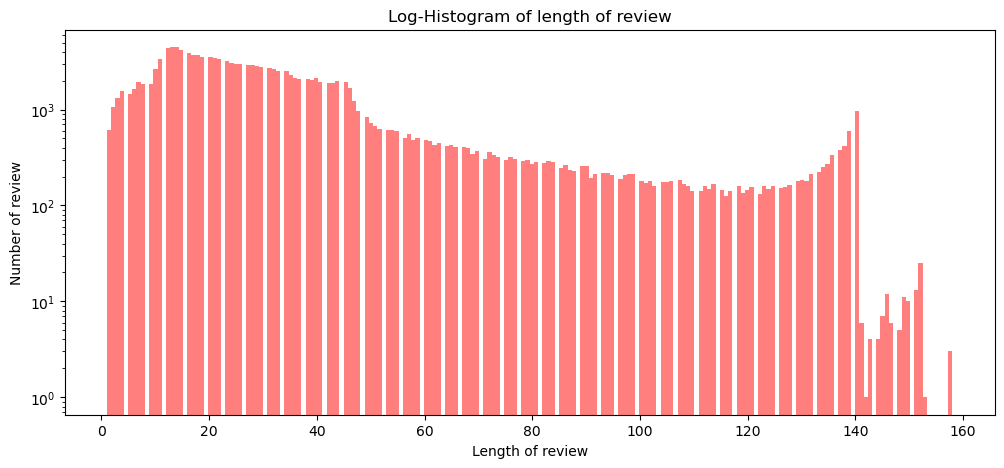

In [11]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_length, bins=200, alpha=0.5, color= 'r')
plt.yscale('log', nonpositive='clip')
#non-positive values in y can be clipped to a very small positive number
# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 x 축 라벨
plt.xlabel('Length of review')
# 그래프 y 축 라벨
plt.ylabel('Number of review')
plt.show()

- 짧은 길이부터 140자까지 고르게 분포되어 있음  
- 20자 이하에 많이 분포되어 있다가 길이가 길어질 수록 점점 적어지다가 140자 부근에서 갑자기 많아짐  
- 140자 제한(한글 기준)이 있는 데이터이기 때문

In [12]:
# 전체 데이터의 통계값

print('리뷰 길이 최대 값: {}'.format(np.max(train_length)))
print('리뷰 길이 최소 값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간 값: {}'.format(np.median(train_length)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간 값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


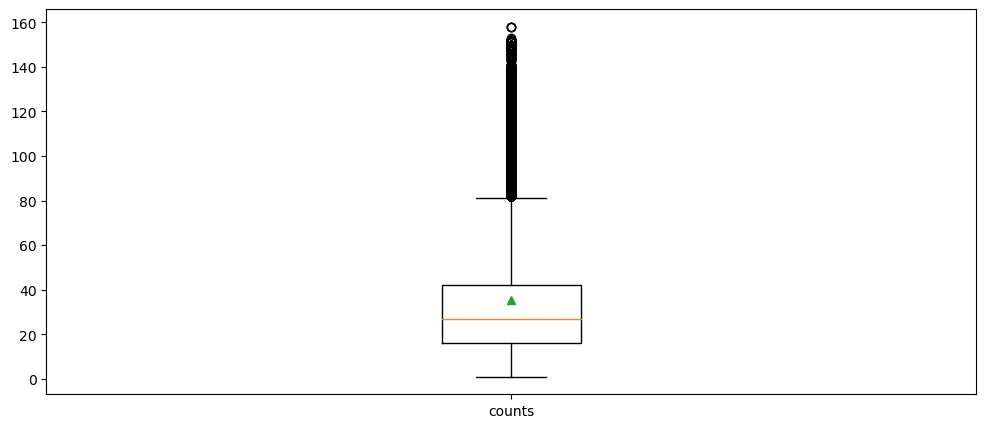

In [13]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot(train_length, labels=['counts'], showmeans=True)
plt.show()

- 길이가 긴 데이터가 꽤 존재함  
- 중간값과 평균값은 아래쪽에 위치  
- 워드클라우드를 이용해 자주 사용된 어휘 알아보기 

In [14]:
# 타입이 문자열인 놈만 걸러줌
train_review = [review for review in train_data['document'] if type(review) is str]

- 워드 클라우드는 기본적으로 영어 텍스트를 지원함  
- 한글을 사용하기 위해 한글 폰트를 설정해야 함  
- 무료 한글폰트를 data-in 에 다운로드(나눔폰트)

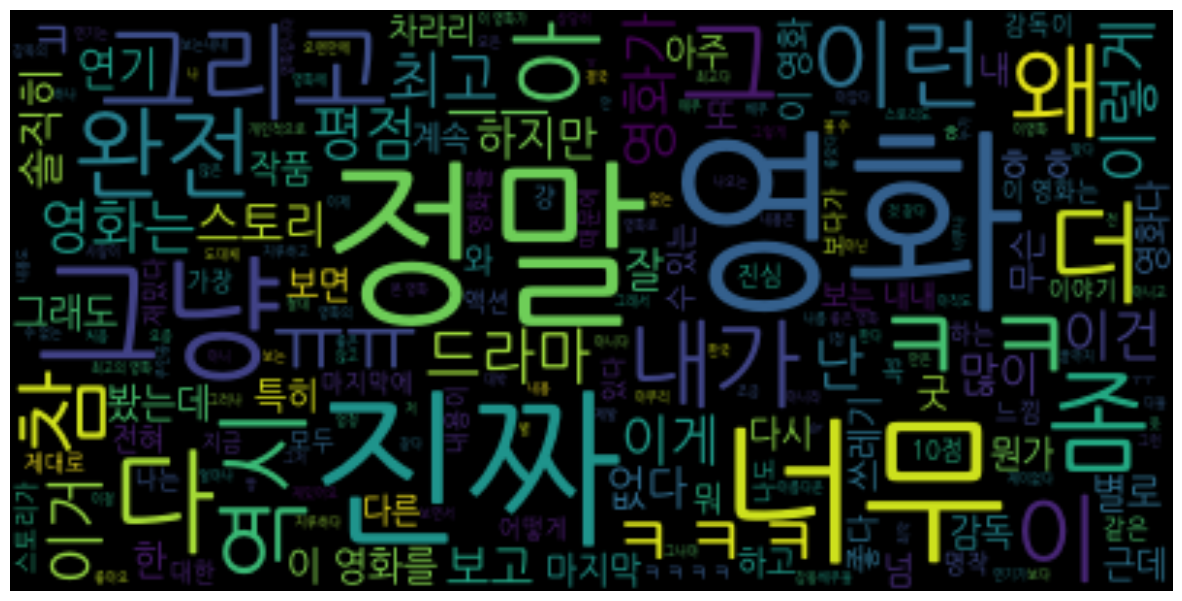

In [15]:
# https://hangeul.naver.com/font 에서 나눔 글꼴 전체 내려받기
# C:\Users\31690\Downloads\nanum-all\나눔 글꼴\나눔고딕\NanumFontSetup_OTF_GOTHIC#NanumGothic.otf 을 data-in에 복붙

# wordcloud 객체 생성
wordclud = WordCloud(font_path = DATA_IN_PATH + 'NanumGothic.otf').generate(' '.join(train_review))
plt.figure(figsize=(15, 10))
plt.imshow(wordclud, interpolation='bilinear')
plt.axis('off')
plt.show()

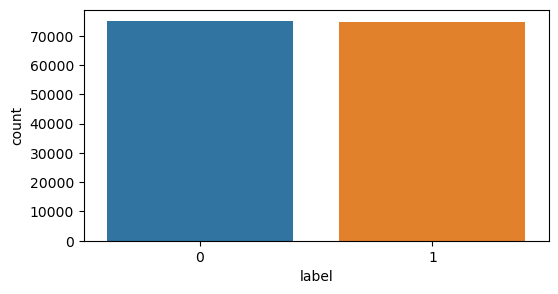

In [16]:
# seaborn의 countplot을 이용해 긍정, 부정 확인하기
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(x=train_data['label'])
plt.show()

In [17]:
# 실제 수치 확인
print("긍정 리뷰 개수: {}".format(train_data['label'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['label'].value_counts()[0]))
# 강사님 평 : 아주 근소하지만 이정도면 훌륭하다

긍정 리뷰 개수: 74827
부정 리뷰 개수: 75173


In [18]:
# 람다식으로 문장을 blank기준으로 split
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

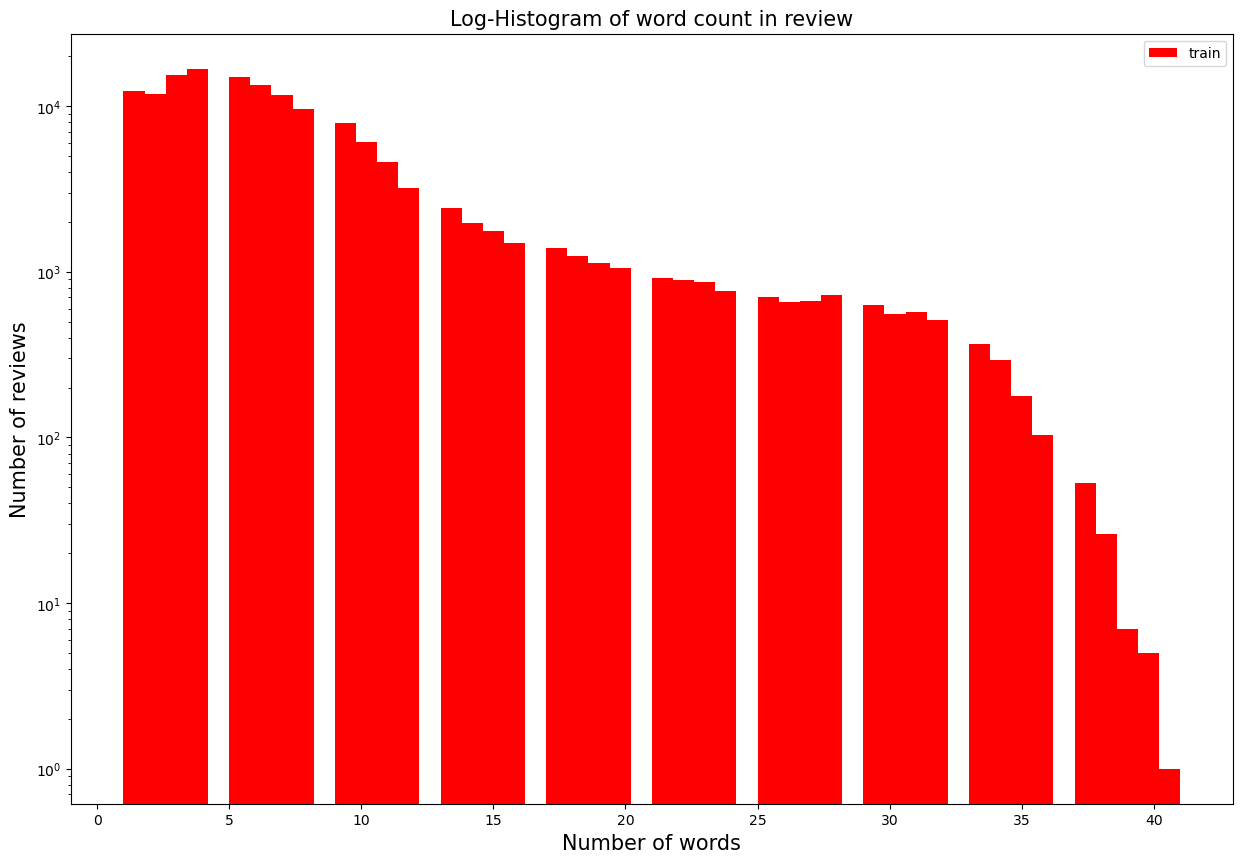

In [19]:
# 단어 수로 histogram 그리기
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonpositive='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)
plt.show()

- 길이의 경우 대부분 5개 정도에 분포되어 있음  
- 30개 이상의 데이터부터는 수가 급격히 줄어듬  

In [20]:
print('리뷰 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('리뷰 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('리뷰 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('리뷰 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('리뷰 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('리뷰 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('리뷰 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

리뷰 단어 개수 최대 값: 41
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 7.58
리뷰 단어 개수 표준편차: 6.51
리뷰 단어 개수 중간 값: 6.0
리뷰 단어 개수 제 1 사분위: 3.0
리뷰 단어 개수 제 3 사분위: 9.0


평균 7 ~ 8 개 정도의 단어 수를 가지고 있고, 중간값의 경우 6개 정도의 단어를 가지고 있음  
- 글자 수 제한때문에 영어 데이터에 비해 길이가 짧음  
- 이 경우 모델에 적용할 최대 단어수를 6개가 아닌 7개로 설정해도 큰 무리가 없음  
- 각 데이터에 대해 특수문자 유무를 확인  
- 리뷰에 자주 사용되는 특별한 특수문자는 없으므로 일반적인 마침표와 물음표만 확인

In [21]:
# 문자열중에 물음표가 있으면 true 아니면 false
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
# 문자열중에 마침표가 있으면 true 아니면 false
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x)) # 마침표
                  
print('물음표가있는 질문: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 질문: {:.2f}%'.format(fullstop * 100))

물음표가있는 질문: 8.25%
마침표가 있는 질문: 51.76%


In [22]:
# 2.전체적인 데이터를 훑어봤으니 데이터 전처리를 할것임

import re
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [26]:
# ... 같은 리뷰는 다 빼야함 
# 한글 자, 모음, 스페이스를 제외한 나머지를 싸그리 다 빼버릴 예정
# 이때 정규식을 사용해서 거를것임
# 파이썬에서 정규 표현식을 사용하는 re 모델
# ^[A] ==> 문장이 A 로 시작하면 replace // [^A] ==> 문장에 A가 포함되지 않은 애들 replace
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0])
print(review_text)

아 더빙 진짜 짜증나네요 목소리


In [27]:
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Komoran
from konlpy.tag import Okt

In [28]:
okt = Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['아', '더빙', '진짜', '짜증나다', '목소리']


In [29]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
# review_text의 token이 stop_words에 없을 경우에 clean_review에 들어감
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['더빙', '진짜', '짜증나다', '목소리']


In [30]:
# 위에서 했던 작업을 함수로 선언

def preprocessing(review, okt, remove_stopwords=False, stop_words=[]):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    if remove_stopwords:
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
    return word_review

In [31]:
# 선언한 함수로 데이터 정제
clean_train_review = []

for review in train_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가
print(clean_train_review[:4])

[['더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'], ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']]


In [32]:
test_data = pd.read_csv(DATA_IN_PATH + 'ratings_test.txt', delimiter='\t', quoting=3 )

clean_test_review = []

for review in test_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가
        
print(clean_test_review[:4])

[['굳다', 'ㅋ'], [], ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'], ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]


In [34]:
# 학습 데이터(150000)의 단어 인덱스와, 테스트 데이터(50000)의 단어 인덱스를 동일하게 사용하기위해 sequences 적용
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

# 단어 사전 정의
word_vocab = tokenizer.word_index 

In [35]:
# 훈련, 테스트데이터상의 더빙이란 단어는 동일한 인덱스를 지녀야 함
print(word_vocab['더빙'])

463


In [37]:
MAX_SEQUENCE_LENGTH = 8 # 문장 최대 길이, 단어의 평균 개수가 8개 정도였기 때문

# 8개가 안되는 단어는 뒤쪽에 0을 붙이겠다
# 8개가 넘는 단어는 잘라버리겠다
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

In [39]:
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) 

In [40]:
import os
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)
    
# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)